In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

## Load and pre-process data

### 1) Global parameters

In [28]:
SOURCE_PATH = os.path.dirname(os.getcwd())

TRAIN_SIZE = 0.7 # size of training data (in %)
VALIDATION_SIZE = 0.2
N_JOBS = 1  # number of jobs to run in parallel
N_SPLITS = 10  # number of splits (k) to be made within the k fold cv
N_ITER = 3  # number of parameter settings that are sampled
SEED = 2294
VERBOSE = True
INPUTS_PATH = os.path.join(SOURCE_PATH, "data", "inputs")
OUTPUTS_PATH = os.path.join(SOURCE_PATH, "data", "outputs")
DATASET_NAMES = ["betadgp_covdgp_data", "betadgp_beta2x2_data", "betadgp_data"]
TARGET_NAME = "betas_dgp"
MODEL_TAG = "FFNN"
STANDARDIZE = True

### 2) Local parameters

In [3]:
DIR_NAMES = os.listdir(os.path.join(INPUTS_PATH))

dgp_name = DIR_NAMES[0]
ds = DATASET_NAMES[0] 

In [4]:
data = pd.read_csv(os.path.join(INPUTS_PATH, dgp_name, ds + ".csv"))
y = data["betas_dgp"].to_numpy()
X = data[["cov_dgp"]].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=(1 - VALIDATION_SIZE))

if STANDARDIZE:
    scaler = StandardScaler()
    X_train_zscore = scaler.fit_transform(X_train)
    X_validation_zscore = scaler.transform(X_validation)
    X_test_zscore = scaler.transform(X_test)

In [5]:
X_train.shape

(18000, 1)

In [6]:
X_validation.shape

(4500, 1)

In [7]:
data.tail()

,Var1,Var2,betas_dgp,cov_dgp
22495,150,146,0.000000,-0.006762
22496,150,147,0.000000,0.086314
22497,150,148,0.000000,0.000372
22498,150,149,0.000000,0.117057
22499,150,150,0.446717,1.000000


array([[<AxesSubplot:title={'center':'betas_dgp'}>]], dtype=object)

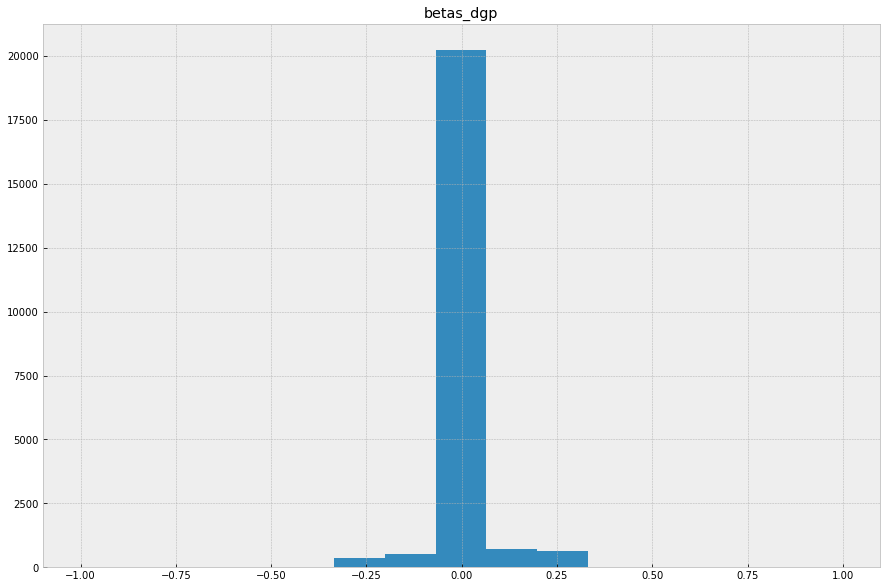

In [8]:
data[["betas_dgp"]].hist(bins=15)

array([[<AxesSubplot:title={'center':'cov_dgp'}>]], dtype=object)

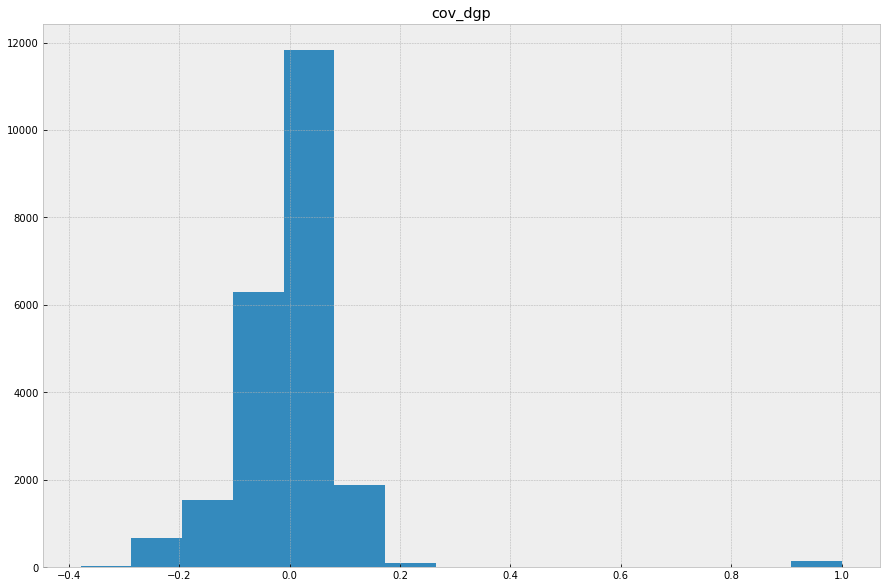

In [9]:
data[["cov_dgp"]].hist(bins=15)

## Model

### 1) Definition and Estimation

We will use the "LinearRegrssion" object of the sklearn package to define the linear regression model object. Since this model has no hyperparameters, we go straight to the estimation of the model parameters on the training data.

In [34]:
# define the FNN model
def FFNN(n_hidden=1,
         n_neurons=30,
         learning_rate=3e-3,
         input_shape=[X_train_zscore.shape[1]],
         loss="mse",
         activation="relu"):
    
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation=activation)) 
        
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

            
# transform the FNN model into a sklearn regressor object
FFNNReg = keras.wrappers.scikit_learn.KerasRegressor(FFNN)

# define wrapper around the FNN regressor
class FFNNWrapper():
    def __init__(self):
        self.model_name = "ffnn"
        self.search_type = 'random'
        self.param_grid = {"n_hidden": [0, 1, 2, 3, 4, 5],
                           "n_neurons": np.arange(1, 100),
                           "learning_rate": reciprocal(3e-4, 3e-2)}
        self.ModelClass = FFNNReg

In [29]:
import numpy as np
from scipy.stats import reciprocal
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, KFold

cv_splits = KFold(n_splits=N_SPLITS)
mse_scorer = make_scorer(mean_squared_error)

### (a) Fixed parameters FNN

In [12]:
wrapper1 = FFNNWrapper()

FFNNStatic = wrapper1.ModelClass
FFNNStatic.fit(X_train_zscore,
               y_train,
               epochs=100,
               validation_data=(X_validation_zscore, y_validation),
               callbacks=[keras.callbacks.EarlyStopping(patience=10)]) 

Train on 18000 samples, validate on 4500 samples
Epoch 1/100
18000/18000 [==============================] - 1s 56us/sample - loss: 0.0230 - val_loss: 0.0075
Epoch 2/100
18000/18000 [==============================] - 0s 27us/sample - loss: 0.0065 - val_loss: 0.0054
Epoch 3/100
18000/18000 [==============================] - 0s 27us/sample - loss: 0.0054 - val_loss: 0.0049
Epoch 4/100
18000/18000 [==============================] - 0s 27us/sample - loss: 0.0050 - val_loss: 0.0046
Epoch 5/100
18000/18000 [==============================] - 0s 26us/sample - loss: 0.0048 - val_loss: 0.0044
Epoch 6/100
18000/18000 [==============================] - 0s 27us/sample - loss: 0.0047 - val_loss: 0.0044
Epoch 7/100
18000/18000 [==============================] - 0s 26us/sample - loss: 0.0046 - val_loss: 0.0043
Epoch 8/100
18000/18000 [==============================] - 0s 26us/sample - loss: 0.0046 - val_loss: 0.0044
Epoch 9/100
18000/18000 [==============================] - 0s 26us/sample - loss: 0.004

In [14]:
y_pred1 = FFNNStatic.predict(X_test_zscore)
mse1 = mean_squared_error(y_true=y_test, 
                         y_pred=y_pred1)

results1 = {"y_pred": y_pred1,
            "mse": mse1}

### (b) Trained parameters FNN

### 1.

In [30]:
wrapper2 = FFNNWrapper()

In [35]:
param_distribs = {"n_hidden": [0, 1, 2, 3],
                  "n_neurons": np.arange(1, 100),
                  "learning_rate": reciprocal(3e-4, 3e-2)}

rnd_search_cv = RandomizedSearchCV(FFNNReg,
                                   param_distribs,
                                   n_iter=N_ITER,
                                   cv=3) 
rnd_search_cv.fit(X_train_zscore,
                  y_train,
                  epochs=10,
                  validation_data=(X_validation_zscore, y_validation),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                  verbose=0)

6000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fc880b1b240>, as the constructor either does not set or modifies parameter learning_rate

### 2.

In [49]:
model_search = RandomizedSearchCV(estimator=wrapper2.ModelClass,
                                  param_distributions=wrapper2.param_grid,
                                  n_iter=N_ITER,
                                  cv=None,
                                  verbose=1,
                                  n_jobs=N_JOBS,
                                  scoring=mse_scorer,
                                  random_state=SEED) 

model_search.fit(X_train_zscore,
                 y_train,
                 validation_data=(X_validation_zscore, y_validation),
                 epochs=100,
                 callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Train on 14400 samples, validate on 4500 samples
Epoch 1/100
14400/14400 [==============================] - 2s 153us/sample - loss: 0.0055 - val_loss: 0.0043
Epoch 2/100
14400/14400 [==============================] - 2s 129us/sample - loss: 0.0048 - val_loss: 0.0042
Epoch 3/100
14400/14400 [==============================] - 2s 123us/sample - loss: 0.0047 - val_loss: 0.0042
Epoch 4/100
14400/14400 [==============================] - 2s 122us/sample - loss: 0.0047 - val_loss: 0.0042
Epoch 5/100
14400/14400 [==============================] - 2s 123us/sample - loss: 0.0047 - val_loss: 0.0043
Epoch 6/100
14400/14400 [==============================] - 2s 123us/sample - loss: 0.0047 - val_loss: 0.0042
Epoch 7/100
14400/14400 [==============================] - 2s 121us/sample - loss: 0.0047 - val_loss: 0.0042
Epoch 8/100
14400/14400 [==============================] - 2s 121us/sample - loss: 0.0047 - val_loss: 0.0042
Epoch 9/100
14400/

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fbbc7390f60>, as the constructor either does not set or modifies parameter n_neurons

In [39]:
y_pred2 = wrapper2.ModelClass.predict(X_test_zscore)
mse2 = mean_squared_error(y_true=y_test, 
                         y_pred=y_pred2)

results2 = {"y_pred": y_pred2,
            "mse": mse2}

### 3) Results

In [49]:
wrapper1.ModelClass.get_params()

{'build_fn': <function __main__.FFNN(n_hidden=1, n_neurons=30, learning_rate=0.003, input_shape=[1], loss='mse', activation='relu')>}

In [50]:
wrapper2.ModelClass.get_params()

{'build_fn': <function __main__.FFNN(n_hidden=1, n_neurons=30, learning_rate=0.003, input_shape=[1], loss='mse', activation='relu')>}

In [41]:
print("FNN fixed parameters MSE " + str(results1["mse"]))
print("FNN trained parameters MSE " + str(results2["mse"]))

FNN fixed parameters MSE 0.004556573240060279
FNN trained parameters MSE 0.006430788941971307
